In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
#Descargar set de datos de Fashion MNIST de Zalando
datos, metadatos = tfds.load('pneumonia_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.ZE930Z_1.0.0/pneumonia_mnist-train.tfrecord*...…

Generating val examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.ZE930Z_1.0.0/pneumonia_mnist-val.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.ZE930Z_1.0.0/pneumonia_mnist-test.tfrecord*...:…

Dataset pneumonia_mnist downloaded and prepared to /root/tensorflow_datasets/pneumonia_mnist/1.0.0. Subsequent calls will reuse this data.


In [4]:
metadatos

tfds.core.DatasetInfo(
    name='pneumonia_mnist',
    full_name='pneumonia_mnist/1.0.0',
    description="""
    # MedMNIST Pneumonia Dataset
    
    The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray
    images. The task is binary-class classification of pneumonia against normal. The
    source training set is split with a ratio of 9:1 into training and validation
    set, and use its source validation set as the test set. The source images are
    gray-scale, and their sizes are (384–2,916) × (127–2,713). The images are
    center-cropped with a window size of length of the short edge and resized into 1
    × 28 × 28.
    """,
    homepage='https://medmnist.com//',
    data_dir='/root/tensorflow_datasets/pneumonia_mnist/1.0.0',
    file_format=tfrecord,
    download_size=3.98 MiB,
    dataset_size=3.66 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),

In [5]:
#podemos ver que se tienen 624 datos para probar, 4708 para entrenar y 524 datos para validar
datos_entrenamiento, datos_pruebas, datos_validacion = datos['train'], datos['test'], datos["val"]

In [6]:
#miramos las clasificaciones que hay
nombres_clases = metadatos.features['label'].names
nombres_clases

['Normal', 'Pneumonia']

In [7]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

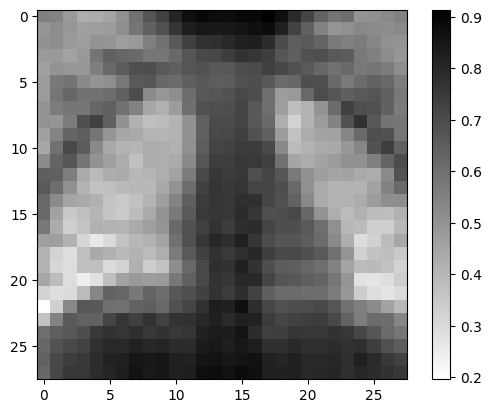

In [8]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

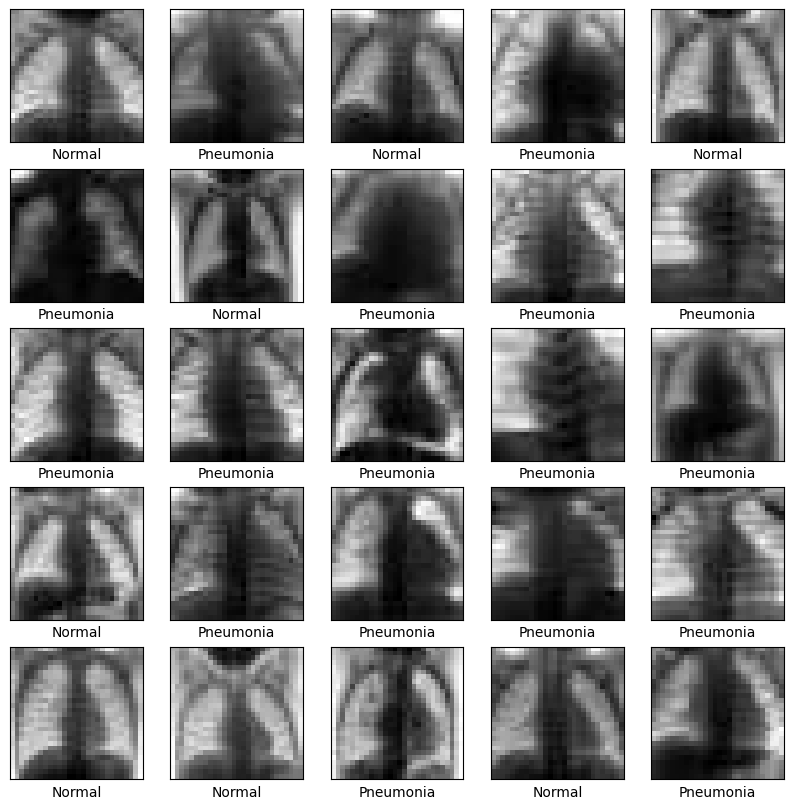

In [9]:
#Dibujar mas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
#guardamos el número de datos que tenemos de prueba y de entrenamiento
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [13]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

4708
624


In [14]:
#ya que son varios datos usaremos lotes para poder entrenar una gran cantidad de datos
TAMANO_LOTE = 32
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [15]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=50, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6868 - loss: 0.8691
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8724 - loss: 0.3061
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9113 - loss: 0.2055
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9301 - loss: 0.1820
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9401 - loss: 0.1554
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.1577
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9443 - loss: 0.1447
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9459 - loss: 0.1439
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9377 - loss: 0.1472
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9482 - loss: 0.1359
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9494 - loss: 0.1276
Epoch 12/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

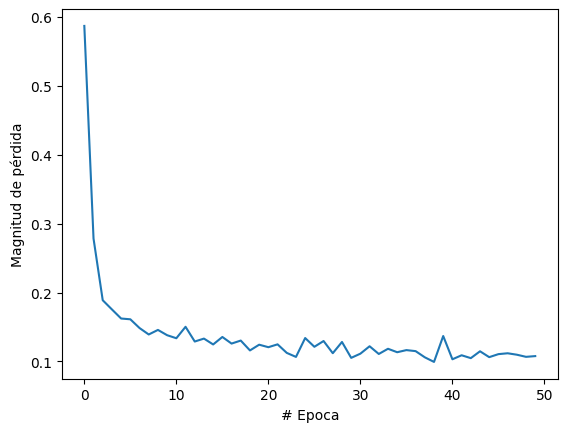

In [16]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

---
### Procesar imagenes


In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# guardar modelo
modelo.save("modelo_pneumonia.keras")


In [18]:
# Función para preprocesar la imagen
def preprocesar_imagen(ruta_imagen):
    imagen = cv.imread(ruta_imagen, cv.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    imagen = cv.resize(imagen, (28, 28))  # Redimensionar a 28x28
    imagen = imagen / 255.0  # Normalizar a valores entre 0 y 1
    imagen = np.expand_dims(imagen, axis=-1)  # Añadir dimensión de canal
    imagen = np.expand_dims(imagen, axis=0)  # Añadir dimensión de batch
    return imagen

In [19]:
# Función para hacer la predicción
def predecir_neumonia(ruta_imagen):
    imagen_procesada = preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(imagen_procesada)
    clase = np.argmax(prediccion)  # 0: Normal, 1: Neumonía
    resultado = "Neumonía" if clase == 1 else "Normal"
    return resultado

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Resultado del análisis: Neumonía


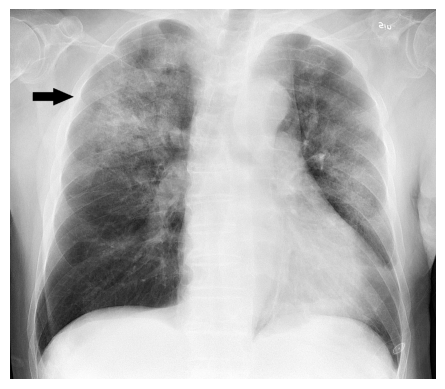

In [27]:
# Ruta de la imagen a analizar
ruta_imagen = "/content/imagenesTest/pulmon1.jpg"
resultado = predecir_neumonia(ruta_imagen)
print(f"Resultado del análisis: {resultado}")

imagen = cv.imread(ruta_imagen, cv.IMREAD_GRAYSCALE)

# Mostrar la imagen con Matplotlib
plt.imshow(imagen, cmap='gray')  # Mostrar en escala de grises
plt.axis("off")  # Ocultar ejes
plt.show()